In [68]:
# I used two naive bayes models to compare which gets the best predictions.
# The first is a from scratch model that is provided by Normalized Nerd's tutorial on naive-Bayes classifiers: https://www.youtube.com/watch?v=3I8oX3OUL6I . 
# The second model is a categorical naive-Bayes model from Scikit-learn.

import numpy as np
import pandas as pd
import seaborn as sns

<Axes: >

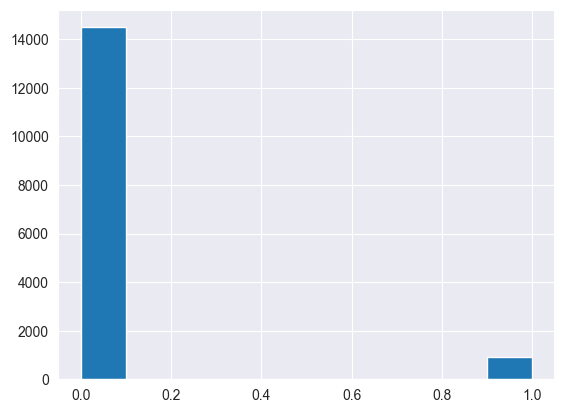

In [69]:
# importing our data
# I omitted the month, week of month, day of week, day of week claimed, week of month claimed, policy number, and rep number categories in the data file
data = pd.read_csv("fraud_oracle2.csv")
# using get dummies to split up the categories, turning them into bool values
dummiesData = pd.get_dummies(data)
# checking how much of our data actually contains examples of insurance fraud
data["FraudFound_P"].hist()

<Axes: >

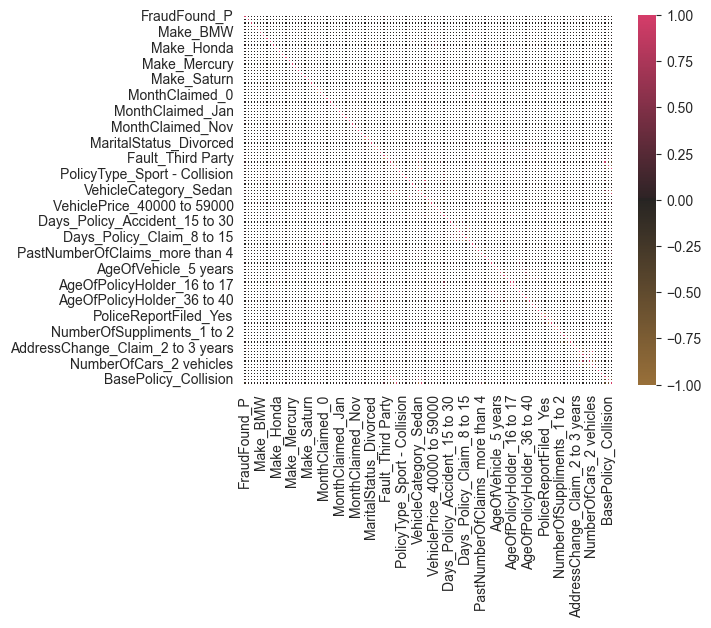

In [70]:
# Creating a heatmap to determine whether our features are truly independent
corr = dummiesData.corr(method="pearson")
cmap = sns.diverging_palette(50, 360, center='dark', as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-1, cmap=cmap, square=True, linewidths=.2)

# As we can see, most of our features are independent. There are a few exceptions, such as BasePolicy_Collision and PolicyType Sport - Collision, indicating that Sport - Collision is likely a sub-policy derived from collision.

In [74]:
def calculate_prior(df, Y): 
    # get a list of all possible outcomes for target
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes: 
        # Get P(target = i)
        prior.append(len(df[df[Y] == i])/len(df))
    return prior


def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    df = df[df[Y]==label]
    # calculate P(feature|targetValue)
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

def naive_bayes_categorical(df, X, Y):
    # Get all columns, omit the last column since it holds the target variable
    features = list(df.columns)[:-1]

    # Get target probabilities 
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over all data entries
    for x in X:
        # get a list of all possible outcomes for the current feature
        labels = sorted(list(df[Y].unique()))
        # set likelihood for all target outcomes to 1
        likelihood = [1]*len(labels)
        # loop over all possibilities for target
        for j in range(len(labels)):
            # loop over all features
            for i in range(len(features)):
                # multiply likelihood of current target outcome by the likelihood of the current outcome with respect to the current feature
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # set final probability to 1
        post_prob = [1]*len(labels)
        # iterate through target outcomes
        for j in range(len(labels)):
            # multiply our P(target) by P(target|features) to get our final probability
            post_prob[j] = likelihood[j] * prior[j]
        # make predictions based on our final probabilities 
        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

In [75]:
# drop our column holding the target variable and add it to the end of our dataset
newDummies = dummiesData.drop(columns=['FraudFound_P']).join(dummiesData[['FraudFound_P']])

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB

# Create our train test split
train, test = train_test_split(newDummies, test_size=.01, random_state=41)

# Create separate variables for our features' values and target's values. 
# Omit the last column since it's our target variable
X_test = test.iloc[:,:-1].values
# Use only the last column since we only want the target variable
Y_test = test.iloc[:,-1].values
# Make predictions using our naive_bayes_categorical model
Y_pred = naive_bayes_categorical(train, X=X_test, Y="FraudFound_P")

# train test fit for our sklearn model
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(newDummies.drop(columns=['FraudFound_P']), newDummies['FraudFound_P'], test_size=.01, random_state=41)
# Creating the model
sklearnModel = CategoricalNB()
# Fitting the model 
sklearnModel.fit(sk_X_train, sk_y_train)
# Making predictions
sk_y_pred = sklearnModel.predict(X_test)
from sklearn.metrics import confusion_matrix


# Get our accuracy for the custom model
accuracy = accuracy_score(Y_pred, Y_test)
print("Custom Model Accuracy:", accuracy)

# Get our accuracy for our sklearn model
sk_accuracy = accuracy_score(sk_y_pred, sk_y_test)
print("Sklearn Model Accuracy:", sk_accuracy)

print("Confusion Matrix:", confusion_matrix(sk_y_test, sk_y_pred))

Custom Model Accuracy: 0.8838709677419355
Sklearn Model Accuracy: 0.9354838709677419
Confusion Matrix: [[143   3]
 [  7   2]]


C:\Users\ianmc\PycharmProjects\MLHW2\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
